# Test for Google Colab Instance

In [ ]:
print("Test for Google Colab")

Test for Google Colab


# Verify the GPU enabled

Changed the resource gpu to T4 GPU

In [ ]:
!nvidia-smi

Tue Dec 16 20:42:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Setting up environment...
/content
Cloning repository...
✓ Repository cloned
/content/pytorch-openpose

✓ Model downloaded
✓ Monkey Patch Applied

Running Inference...

[System] Starting Structural Weight Transfer...
[System] Successfully mapped 184/184 layers.
✓ Model loaded successfully!
Processing: /content/test_data/test.jpg


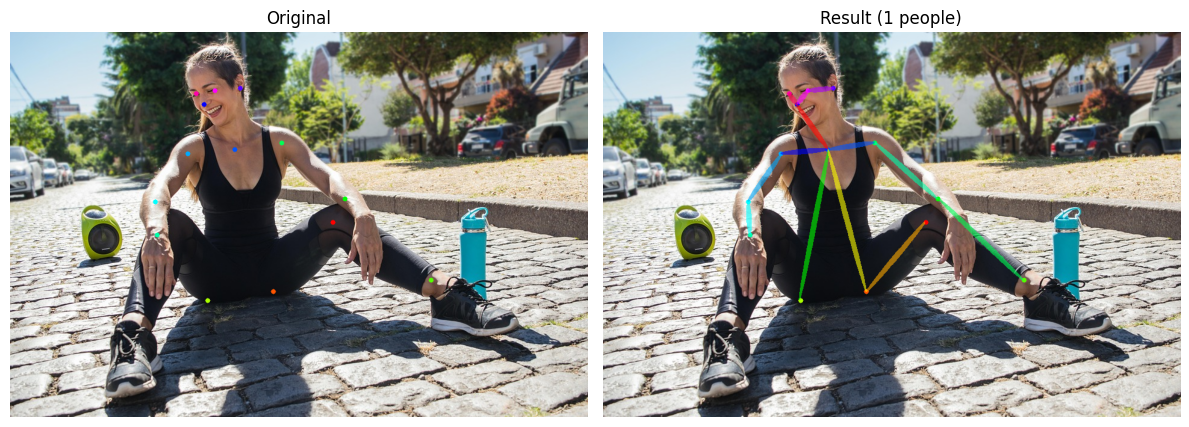


✓ Process Complete.


In [13]:
import os
import sys
import shutil
import urllib.request
import cv2
import matplotlib.pyplot as plt
import torch
import re

# 1. SETUP & CLEAN INSTALL
# ==============================================================================
print("Setting up environment...")
%cd /content

if os.path.exists('pytorch-openpose'):
    shutil.rmtree('pytorch-openpose')

print("Cloning repository...")
!git clone https://github.com/Hzzone/pytorch-openpose.git > /dev/null 2>&1
print("✓ Repository cloned")

%cd /content/pytorch-openpose
sys.path.insert(0, '/content/pytorch-openpose')


# 2. DOWNLOAD ASSETS
# ==============================================================================
print("\n" + "="*60)
print("Downloading assets...")
print("="*60)

os.makedirs('model', exist_ok=True)
model_path = 'model/body_pose_model.pth'

if not os.path.exists(model_path):
    print("Downloading Body Pose Model...")
    urllib.request.urlretrieve(
        'https://www.dropbox.com/s/5v654d2u65fuvyr/body_pose_model.pth?dl=1',
        model_path
    )
    print("✓ Model downloaded")

os.makedirs('../test_data', exist_ok=True)
image_path = '/content/test_data/test.jpg'
if not os.path.exists(image_path):
    urllib.request.urlretrieve(
        'https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Two_dancers.jpg/640px-Two_dancers.jpg',
        image_path
    )


# 3. PRODUCTION FIX: SEQUENTIAL MAPPING
# ==============================================================================
# We define a smart transfer function that aligns layers by order, not just name.
from src import util

def smart_transfer(model, model_weights):
    print("\n[System] Starting Structural Weight Transfer...")

    if 'state_dict' in model_weights:
        model_weights = model_weights['state_dict']

    transfered_model_weights = {}
    model_keys = list(model.state_dict().keys())

    # 1. Group Source Keys (File) by Block Name
    # Regex captures: (prefix)(block_name).(index/name).(rest)
    # Example: "module.model0.0.weight" -> block="model0", index="0", type="weight"
    source_grouped = {}
    for key in model_weights.keys():
        # Remove 'module.' prefix if present
        clean_key = key.replace('module.', '')
        parts = clean_key.split('.')
        block_name = parts[0]  # e.g., model0

        if block_name not in source_grouped:
            source_grouped[block_name] = []
        source_grouped[block_name].append(key)

    # 2. Sort Source Keys logically to match Model order
    # Sort criteria:
    #   1. Integer index (if strictly numeric)
    #   2. 'weight' comes before 'bias' (to match PyTorch defaults)
    for block in source_grouped:
        def sort_key(k):
            clean = k.replace('module.', '')
            parts = clean.split('.')
            # Extract index if it's a number (e.g., '0' in 'model0.0.weight')
            try:
                idx = int(parts[1])
            except ValueError:
                idx = 999 # Fallback if not numbered

            # Prioritize weight over bias
            is_bias = 1 if 'bias' in k else 0
            return (idx, is_bias)

        source_grouped[block].sort(key=sort_key)

    # 3. Align Target Keys (Model) with Sorted Source Keys
    success_count = 0

    # We maintain a pointer for every block in the source
    block_pointers = {b: 0 for b in source_grouped.keys()}

    for target_key in model_keys:
        parts = target_key.split('.')
        block_name = parts[0] # e.g., model0

        # If this block exists in the file
        if block_name in source_grouped:
            ptr = block_pointers[block_name]
            available_keys = source_grouped[block_name]

            if ptr < len(available_keys):
                source_key = available_keys[ptr]

                # Assign logic
                transfered_model_weights[target_key] = model_weights[source_key]

                # Increment pointer
                block_pointers[block_name] += 1
                success_count += 1
            else:
                print(f"⚠ Warning: Model expects more layers in {block_name} than file has.")

    print(f"[System] Successfully mapped {success_count}/{len(model_keys)} layers.")
    return transfered_model_weights

# Apply the patch
util.transfer = smart_transfer
print("✓ Monkey Patch Applied")


# 4. RUN INFERENCE
# ==============================================================================
print("\n" + "="*60)
print("Running Inference...")
print("="*60)

try:
    from src.body import Body
    from src.util import draw_bodypose

    # Initialize
    body_estimation = Body(model_path)
    print("✓ Model loaded successfully!")

    # Process Image
    print(f"Processing: {image_path}")
    oriImg = cv2.imread(image_path)

    # Detect
    candidate, subset = body_estimation(oriImg)
    canvas = draw_bodypose(oriImg, candidate, subset)

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB))
    axes[0].axis('off')
    axes[0].set_title('Original')

    axes[1].imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    axes[1].axis('off')
    axes[1].set_title(f'Result ({len(subset)} people)')

    plt.tight_layout()
    plt.show()
    print("\n✓ Process Complete.")

except Exception as e:
    print(f"\n✗ Error: {e}")